<a href="https://colab.research.google.com/github/gordoaraujo/cl_dl_challenge/blob/main/Helper_Hurricane_Damage_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hurricane Damage Detector

## Get and Load Dataset

In [ ]:
!pip install --upgrade --no-cache-dir gdown

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14774 sha256=74720053934f760fe60006a244ec8d54d7c7d93f46b64b0d2ac6fd0a8442dde1
  Stored in directory: /tmp/pip-ephem-wheel-cache-bp9863ub/wheels/fb/c3/0e/c4d8ff8bfcb0461afff199471449f642179b74968c15b7a69c
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.2.2
    Uninstalling gdown-4.2.2:
      Successfully uninstalled gdown-4.2.2


In [ ]:
!gdown --id 1pByxsenTnJGBKnKhLTXBqbUN_Kbm7PNK

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1pByxsenTnJGBKnKhLTXBqbUN_Kbm7PNK
To: /content/hurricane_detector.zip
100% 39.7M/39.7M [00:00<00:00, 44.6MB/s]


In [ ]:
!unzip -q hurricane_detector.zip

In [ ]:
ls -l

total 38748
-rw-r--r-- 1 root root 39662128 Jan 12 16:47 hurricane_detector.zip
drwxr-xr-x 1 root root     4096 Jan  7 14:33 sample_data/
drwxr-xr-x 4 root root     4096 Jan 12 16:47 test_hurricane/
drwxr-xr-x 4 root root     4096 Jan 12 16:47 train_hurricane/


In [ ]:
!sudo apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 1s (41.2 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 155229 files and directories currently instal

In [ ]:
!tree --dirsfirst --filelimit 2 ./train_hurricane/

./train_hurricane/
├── damage [655 entries exceeds filelimit, not opening dir]
└── no_damage [703 entries exceeds filelimit, not opening dir]

2 directories, 0 files


In [ ]:
!tree --dirsfirst --filelimit 2 ./test_hurricane/

./test_hurricane/
├── damage [5895 entries exceeds filelimit, not opening dir]
└── no_damage [6333 entries exceeds filelimit, not opening dir]

2 directories, 0 files


## Load Dependencies

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix,\
                            classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

print('TF Version:', tf.__version__)

TF Version: 2.7.0


## Utility functions to create dataset generators

In [ ]:
IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['no_damage', 'damage']

# call this function before running any model to get data into train and validation splits
# data is loaded as a TF dataset in a memory efficient format
def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./train_hurricane",
        validation_split=0.2,
        subset="training",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./train_hurricane",
        validation_split=0.2,
        subset="validation",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    train_ds = train_ds.prefetch(buffer_size=25)
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds

# call this function on any trained model to get prediction labels on the test data
# this loads the test dataset from the test directory as a test dataset
# iterates through the above dataset and returns the true labels as well as the predicted labels
def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./test_hurricane",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100),
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    predictions = predictions.ravel()
    test_labels = np.array(test_labels)

    return test_labels, predictions


### Example usage of the above functions

```
train_ds, val_ds = prepare_train_and_val_datasets()

model = <BIG CNN MODEL>

history = model.fit(
    train_ds, epochs=10,
    validation_data=val_ds,
)

y_true, y_pred = eval_model_on_test(model)


In [ ]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 1358 files belonging to 2 classes.
Using 1087 files for training.
Found 1358 files belonging to 2 classes.
Using 271 files for validation.


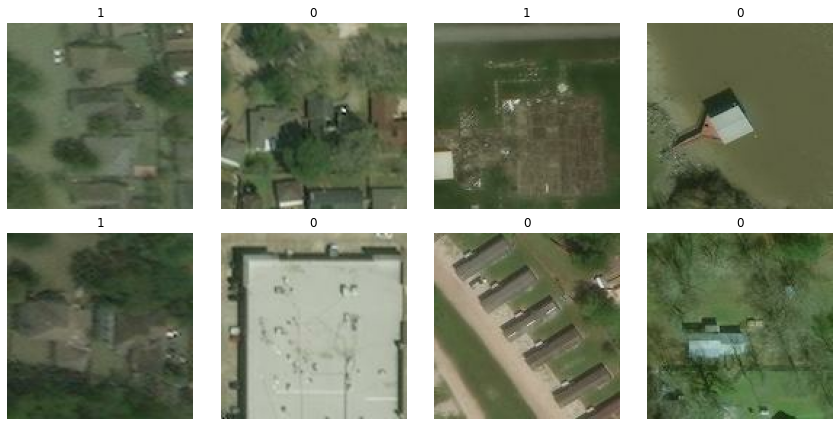

In [ ]:
plt.figure(figsize=(12, 6))

for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.tight_layout()

## If you want to apply data augmentation operations on the train dataset

Go to the `prepare_train_and_val_datasets(...)` and you can add augmentation operations directly to the train dataset as follows:

```
train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                    .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=tf.data.AUTOTUNE))
```


Remember to check [`tf.image`](https://www.tensorflow.org/api_docs/python/tf/image#image_adjustments) for various image transforms available and you can play around with augmentations

__Be careful here and don't add too many transforms which can distort the images beyond recognition__